In [1]:
import re

import pandas as pd
import jinja2  # Templating library (prompt templates)
from dotenv import load_dotenv
from openai import OpenAI
import tiktoken  # Estimate OpenAI tokens

load_dotenv("../.env")
client = OpenAI()

In [2]:
df = pd.read_csv("../data/ASAP2_new_IN_data_only.csv")
df

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task
0,AAAOPP13416000019936,4,"Being a Seagoing Cowboy is really fun, but als...",test,private,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Black/African American,M,6,538.0,MI,Text dependent
1,AAAOPP13416000055926,5,"To whom ever reads this at the end, you might ...",test,public,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,6,367.0,MI,Text dependent
2,AAAOPP13416000005911,3,Have you ever wondered about what you might do...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Two or more races/Other,F,6,498.0,MI,Text dependent
3,AAAOPP13416000019800,3,I believe that you should join the Seagoing Co...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,317.0,MI,Text dependent
4,AAAOPP13416000019823,4,Would you like to participate in the Seagoing ...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,443.0,MI,Text dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,AAAOPP13416000218424,1,We've been discovering things almost everyday....,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,259.0,MI,Text dependent
11822,AAAOPP13416000254175,1,In 1976 the queation was and everyone was also...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Two or more races/Other,M,8,226.0,MI,Text dependent
11823,AAAOPP13416000260386,1,25 years ago there was a face discovered by na...,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,163.0,MI,Text dependent
11824,AAAOPP13416000292300,1,The\n\nfirst thing that i should include in my...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,F,8,292.0,MI,Text dependent


In [8]:
environment = jinja2.Environment(loader=jinja2.FileSystemLoader("prompt_templates"))
template = environment.get_template("scoring_prompt.jinja2")

In [43]:
sample = df.sample(1)

print("Original Score: ", sample["score"].item())

# response = client.chat.completions.create(
#     model="o3-mini-2025-01-31",
#     messages=[
#         {
#             "role": "user", 
#             "content": template.render(sample.to_dict(orient="records")[0])
#         }
#     ],
#     response_format={
#         "type": "json_schema",
#         "json_schema": {
#             "name": "holistic_score_schema",
#             "schema": {
#                 "type": "object",
#                 "properties": {
#                     "score": {
#                         "description": "A single digit from 1-6 representing the holistic core of the essay",
#                         "type": "integer"
#                     },
#                     "additionalProperties": False
#                 }
#             }
#         }
#     }
# )

print(response.choices[0].message.content);

Original Score:  3
{"score": 3}


# Construct Batch Input

OpenAI gives us a discount if we send the job as a batch.

Format for batch input is a JSONL file with the following structure:
```
{
  "custom_id": "request-1",
  "method": "POST",
  "url": "/v1/chat/completions",
  "body": {
    "model": "gpt-3.5-turbo-0125",
    "messages": [{
      "role": "user",
      "content": "Hello world!"
    }]
  }
}
```

In [21]:
def format_request(custom_id, template_inputs, template, model_name="o3-mini-2025-01-31"):
    return {
        "custom_id": custom_id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "o3-mini-2025-01-31",
            "messages": [{
                "role": "user",
                "content": template.render(**template_inputs)
            }]
        }
    }

batch_input = pd.DataFrame([
    format_request(
        row.essay_id,
        {
            "assignment": row.assignment,
            "full_text": row.full_text,
        },
        template,
    )
    for row in df.itertuples()
])

batch_input.to_json("../data/batch_input.jsonl", orient="records", lines=True)

batch_input

,custom_id,method,url,body
0,AAAOPP13416000019936,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
1,AAAOPP13416000055926,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
2,AAAOPP13416000005911,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
3,AAAOPP13416000019800,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
4,AAAOPP13416000019823,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
...,...,...,...,...
11821,AAAOPP13416000218424,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
11822,AAAOPP13416000254175,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
11823,AAAOPP13416000260386,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."
11824,AAAOPP13416000292300,POST,/v1/chat/completions,"{'model': 'o3-mini-2025-01-31', 'messages': [{..."


## Estimate pricing

This is based on the list price. Actual price should be 50% lower since we are using a batch job.

In [34]:
def num_tokens_from_body(row, model_name="o3-mini-2025-01-31", split_on=None) -> int:
    """Returns the number of tokens in the messages field of the body column."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = 0
    for message in row["body"]["messages"]:
        text = message["content"]
        if split_on:
            text = text.split(split_on)[0]
        num_tokens += len(encoding.encode(text))
    return num_tokens

batch_input["token_count"] = batch_input.apply(num_tokens_from_body, axis="columns")
batch_input["static_token_count"] = batch_input.apply(num_tokens_from_body, axis="columns", split_on="```")
batch_input.describe()

,token_count,dynamic_token_count
count,11826.000000,11826.0
mean,1350.343903,838.0
std,157.357335,0.0
min,1082.000000,838.0
25%,1229.000000,838.0
50%,1325.000000,838.0
75%,1442.000000,838.0
max,2388.000000,838.0


In [41]:
total_input_tokens = batch_input.token_count.sum()
static_input_tokens = batch_input.dynamic_token_count.sum()
dynamic_input_tokens = total_input_tokens - static_input_tokens
dynamic_price = 1.1 / 1_000_000 # Price per token
static_price = .55 / 1_000_000 # Price per cached token

print(f"Price for Static Tokens: ${static_input_tokens * static_price:.2f}")
print(f"Price for Dynamic Tokens: ${dynamic_input_tokens * dynamic_price:.2f}")
print(f"Total Price: ${static_input_tokens * static_price + dynamic_input_tokens * dynamic_price:.2f}")

Price for Static Tokens: $5.45
Price for Dynamic Tokens: $6.66
Total Price: $12.12


## Creat Batch Job in OpenAI

In [22]:
batch_input_file = client.files.create(
    file=open("../data/batch_input.jsonl", "rb"),
    purpose="batch"
)
batch_input_file_id = batch_input_file.id
batch_details = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description": "ASAP Scoring 1"
    }
)
print(f"batch-id:\n{batch_details.id}\n")
print(batch_details)

file-QpMFaCikP6tBAVVa9vRJhx
batch-id:
batch_67cc701c87048190a27935e671f55cd7
Batch(id='batch_67cc701c87048190a27935e671f55cd7', completion_window='24h', created_at=1741451292, endpoint='/v1/chat/completions', input_file_id='file-QpMFaCikP6tBAVVa9vRJhx', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1741537692, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'ASAP Scoring 1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [48]:
batch = client.batches.retrieve("batch_67cc701c87048190a27935e671f55cd7")
print(batch)

Batch(id='batch_67cc701c87048190a27935e671f55cd7', completion_window='24h', created_at=1741451292, endpoint='/v1/chat/completions', input_file_id='file-QpMFaCikP6tBAVVa9vRJhx', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1741456128, error_file_id=None, errors=None, expired_at=None, expires_at=1741537692, failed_at=None, finalizing_at=1741453926, in_progress_at=1741451296, metadata={'description': 'ASAP Scoring 1'}, output_file_id='file-PrM33kFw5nVgfnoDgCMwL9', request_counts=BatchRequestCounts(completed=11826, failed=0, total=11826))


In [71]:
file_response = client.files.content("file-PrM33kFw5nVgfnoDgCMwL9")

In [88]:
import io

results = pd.read_json(io.StringIO(file_response.text), lines=True)
results = results.drop(columns=["id", "error"])
results

,custom_id,response
0,AAAOPP13416000019936,"{'status_code': 200, 'request_id': '88ccb0012e..."
1,AAAOPP13416000055926,"{'status_code': 200, 'request_id': '1f6ac2d811..."
2,AAAOPP13416000005911,"{'status_code': 200, 'request_id': '755a877349..."
3,AAAOPP13416000019800,"{'status_code': 200, 'request_id': '25dbde1785..."
4,AAAOPP13416000019823,"{'status_code': 200, 'request_id': 'f7a836a71f..."
...,...,...
11821,AAAOPP13416000218424,"{'status_code': 200, 'request_id': '644cf77f6c..."
11822,AAAOPP13416000254175,"{'status_code': 200, 'request_id': 'd53947dfac..."
11823,AAAOPP13416000260386,"{'status_code': 200, 'request_id': '37204abf76..."
11824,AAAOPP13416000292300,"{'status_code': 200, 'request_id': 'a579c358e5..."


In [116]:
responses = results.apply(lambda x: x["response"]["body"]["choices"][0]["message"]["content"], axis=1)
results["o3_mini_response"] = responses

def extract_first_digit(string):
    match = re.search(r'[1-6]', string)
    if match:
        return match.group(0)
    else:
        return None

o3_scores = []
for response in responses:
    score = extract_first_digit(response)
    o3_scores.append(int(score))
    if score is None:
        print(response)
        
results["o3_mini_score"] = o3_scores

In [117]:
out_df = df.merge(
    results[["custom_id", "o3_mini_response", "o3_mini_score"]],
    left_on="essay_id",
    right_on="custom_id").drop(columns="custom_id")
out_df.to_csv("../results/asap_w_o3_mini_scores.csv")
out_df

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task,o3_mini_response,o3_mini_score
0,AAAOPP13416000019936,4,"Being a Seagoing Cowboy is really fun, but als...",test,private,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Black/African American,M,6,538.0,MI,Text dependent,4,4
1,AAAOPP13416000055926,5,"To whom ever reads this at the end, you might ...",test,public,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,6,367.0,MI,Text dependent,5,5
2,AAAOPP13416000005911,3,Have you ever wondered about what you might do...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Two or more races/Other,F,6,498.0,MI,Text dependent,I would give this essay a score of 4. While th...,4
3,AAAOPP13416000019800,3,I believe that you should join the Seagoing Co...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,317.0,MI,Text dependent,4,4
4,AAAOPP13416000019823,4,Would you like to participate in the Seagoing ...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,443.0,MI,Text dependent,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,AAAOPP13416000218424,1,We've been discovering things almost everyday....,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,259.0,MI,Text dependent,3,3
11822,AAAOPP13416000254175,1,In 1976 the queation was and everyone was also...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Two or more races/Other,M,8,226.0,MI,Text dependent,3,3
11823,AAAOPP13416000260386,1,25 years ago there was a face discovered by na...,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,163.0,MI,Text dependent,3,3
11824,AAAOPP13416000292300,1,The\n\nfirst thing that i should include in my...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,F,8,292.0,MI,Text dependent,3,3


In [118]:
out_df[["score", "o3_mini_score"]].corr()

,score,o3_mini_score
score,1.000000,0.551248
o3_mini_score,0.551248,1.000000


## Quick Viz

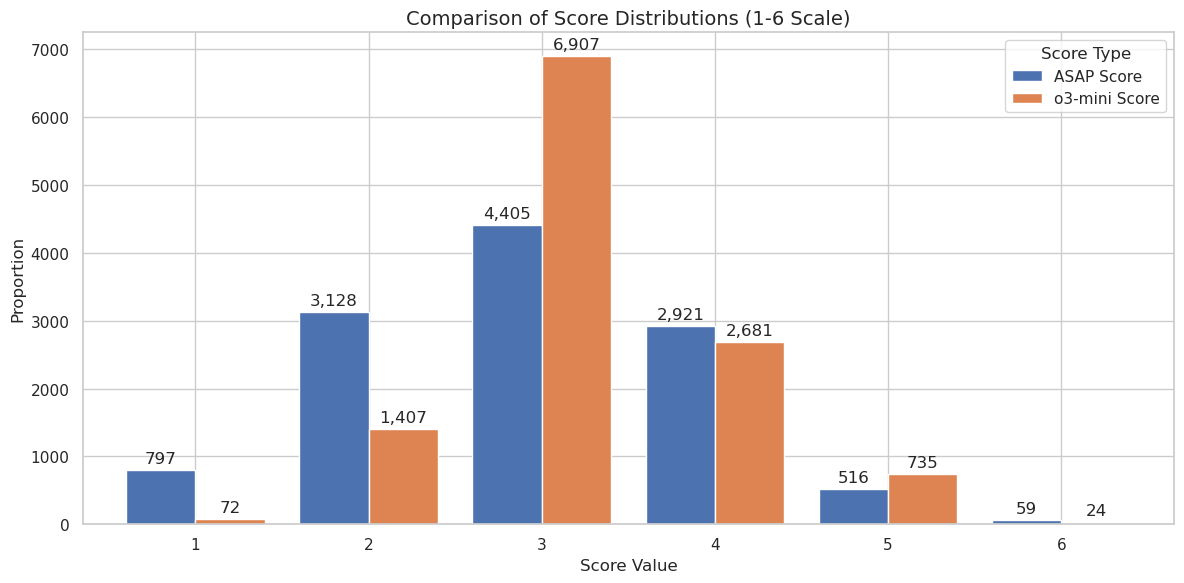

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Calculate the frequency counts for each score (1-6)
score_counts = out_df["score"].value_counts().reindex(range(1, 7), fill_value=0)
o3_mini_counts = out_df["o3_mini_score"].value_counts().reindex(range(1, 7), fill_value=0)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'ASAP Score': score_counts.values,
    'o3-mini Score': o3_mini_counts.values
}, index=range(1, 7))

# Create the side-by-side bar chart
ax = plot_data.plot(kind='bar', width=0.8, figsize=(12, 6))

# Add labels and title
plt.xlabel('Score Value', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Comparison of Score Distributions (1-6 Scale)', fontsize=14)
plt.xticks(rotation=0)  # Keep x-labels horizontal

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3)

plt.legend(title='Score Type')
plt.tight_layout()
plt.show();